In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torchvision
import torchvision.transforms as T
import gc
from IPython.display import clear_output

In [2]:
filenames = [name for name in os.listdir("./images")]

In [3]:
maxnum = 8785

data = torch.zeros((maxnum, 3, 227, 227))

for idx, i in enumerate(filenames):
  if idx == maxnum: break
  if i[-3:] == 'jpg':
    image = torchvision.io.read_image("./images/"+i)

    data[idx] = T.Resize((227, 227))(image)

    if idx%500 == 0:
      print(f"loaded {(idx/maxnum)*100}%")


loaded 0.0%
loaded 5.691519635742743%
loaded 11.383039271485487%
loaded 17.07455890722823%
loaded 22.766078542970973%
loaded 28.457598178713717%
loaded 34.14911781445646%
loaded 39.8406374501992%
loaded 45.53215708594195%
loaded 51.22367672168468%
loaded 56.91519635742743%
loaded 62.606715993170184%
loaded 68.29823562891292%
loaded 73.98975526465567%
loaded 79.6812749003984%
loaded 85.37279453614116%
loaded 91.0643141718839%
loaded 96.75583380762663%


In [4]:
data = data/255
data = data.resize(maxnum, 3, 227, 227)

C:\Users\Klayton Smith\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [5]:
filenames = [name for name in os.listdir("./masks")]

In [6]:
maxnum = 318

masks = torch.zeros((maxnum, 3, 227, 227))

for idx, i in enumerate(filenames):
  if idx == maxnum: break
  if i[-3:] == 'png':
    image = torchvision.io.read_image("./masks/"+i)

    masks[idx] = T.Resize((227, 227))(image)

    if idx%100 == 0:
      print(f"loaded {(idx/maxnum)*100}%")


loaded 0.0%
loaded 31.446540880503143%
loaded 62.893081761006286%
loaded 94.33962264150944%


In [7]:
masks = (masks*100).clamp(max = 1)

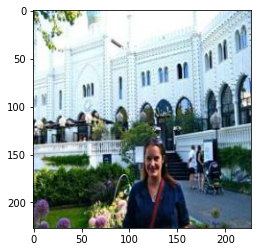

In [8]:
plt.imshow(data[0].permute(1,2,0).detach().numpy())

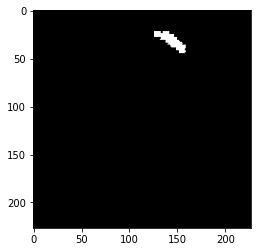

In [9]:
plt.imshow((T.GaussianBlur(5, sigma=(1, 10))(masks[201].permute(1,2,0))*10000).clamp(min=0, max=1).detach().numpy())

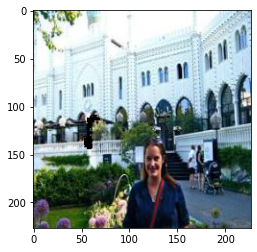

In [10]:
plt.imshow((data[0]-masks[0]).clamp(max=1, min=0).permute(1,2,0).detach().numpy())

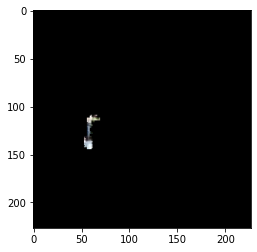

In [11]:
plt.imshow((data[0]- torchvision.transforms.functional.invert(masks[0])).clamp(max=1, min=0).permute(1,2,0).detach().numpy())

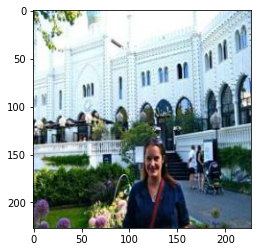

In [12]:
plt.imshow(((data[0]- torchvision.transforms.functional.invert(masks[0])).clamp(max=1, min=0) + (data[0]-masks[0]).clamp(max=1, min=0)).permute(1,2,0).detach().numpy())

In [13]:
class ContextEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c2d1 = nn.Conv2d(3, 96, 11, stride=4)
        self.relu1 = nn.LeakyReLU()
        self.mp1 = nn.MaxPool2d(3, 2)
        self.c2d2 = nn.Conv2d(96, 256, 5, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.mp2 = nn.MaxPool2d(3, 2)
        self.c2d3 = nn.Conv2d(256, 384, 3, padding=1)
        self.relu3 = nn.LeakyReLU()
        self.c2d4 = nn.Conv2d(384, 384, 3, padding=1)
        self.relu4 = nn.LeakyReLU()
        self.c2d5 = nn.Conv2d(384, 256, 3, padding=1)
        self.relu5 = nn.LeakyReLU()
        self.mp3 = nn.MaxPool2d(3,2)

        self.cwfc = nn.ConvTranspose2d(256, 256, 1, stride=1,groups=256)

        self.uc1 = nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2)
        self.uc2 = nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2)
        self.uc3 = nn.ConvTranspose2d(64, 64, 5, stride=2, padding=2)
        self.uc4 = nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2)
        self.uc5 = nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2)
        self.resize = torchvision.transforms.Resize((227,227))

    def anet(self, img):
        res = img

        res = self.c2d1(res)
        res = self.relu1(res)
        res = self.mp1(res)
        res = self.c2d2(res)
        res = self.relu2(res)
        res = self.mp2(res)
        res = self.c2d3(res)
        res = self.relu3(res)
        res = self.c2d4(res)
        res = self.relu4(res)
        res = self.c2d5(res)
        res = self.relu5(res)
        res = self.mp3(res)

        return res
    def dec(self, dat):
        res = dat

        res = self.uc1(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc2(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc3(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc4(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc5(res)
        res = torch.nn.functional.tanh(res)
        res = self.resize(res)

        return res

    def forward(self, img):
        res = img

        res = self.anet(res)
        res = self.cwfc(res)
        res = self.dec(res)

        return res


# I'll try using this but the paper says they couldn't get it to converge so we'll see what happens
class Adversarial(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4)
        self.conv2 = nn.Conv2d(64, 128, 4)
        self.conv3 = nn.Conv2d(128, 256, 4)
        self.conv4 = nn.Conv2d(256, 512, 4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(100352, 2)


    def forward(self, img):
        res = img
        res = self.conv1(res)
        res = self.conv2(res)
        res = self.conv3(res)
        res = self.conv4(res)
        res = self.flatten(res)
        res = self.linear(res)
        return res
        


In [14]:
torch.cuda.is_available()
torch.cuda.empty_cache()
gc.collect()
device = torch.device('cuda')
try:
    del model
except:
    pass

In [15]:
model = ContextEncoder()
model.to(device)
loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
batchsize = len(data)//25
epoch = 4210

In [16]:
model.load_state_dict(torch.load("./model_saves/4210.pt"))

<All keys matched successfully>

epoch #4575
avg loss: tensor([0.0003], device='cuda:0', grad_fn=<DivBackward0>)


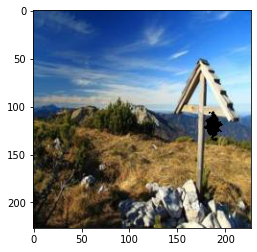

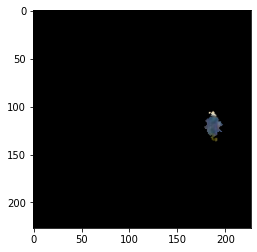

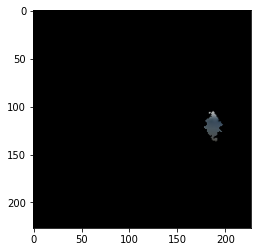

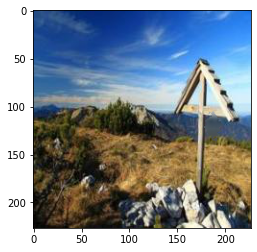

In [17]:

while True:
  loss = torch.tensor([0]).to(device).float()
  avg_loss = torch.tensor([0]).to(device).float()
  batches = 0
  for i in range(0, len(data), batchsize):
    chunk = data[i:i+batchsize]
    batchmasks = T.RandomAffine(degrees=(0, 360), translate=(0, 0.1), scale=(1.5, 2))(masks[torch.randint(len(masks), (len(chunk),))])

    batch = (chunk - batchmasks).clamp(max=1, min=0)
    batchres = (chunk - torchvision.transforms.functional.invert(batchmasks)).clamp(max=1, min=0)
    batchmasks = batchmasks.to(device)

    batch = batch.to(device)
    batchres = batchres.to(device)

    reconstructed_images = model(batch)

    reconstructed_images -= T.functional.invert(batchmasks)*100

    reconstructed_images = reconstructed_images.clamp(max=1, min=0)

    loss = loss_fun(reconstructed_images, batchres)

    loss.backward()
      
    optimizer.step()
    optimizer.zero_grad()
    avg_loss += loss
    batches += 1

  epoch += 1

  if epoch %1 == 0:
    clear_output()
    print(f"epoch #{epoch}")
    print(f"avg loss: {(avg_loss/batches)}")
    plt.imshow(batch[0].cpu().permute(1,2,0).detach().numpy())
    plt.show()
    plt.imshow(batchres[0].cpu().permute(1,2,0).detach().numpy())
    plt.show()
    plt.imshow((model.forward(batch[0]).cpu()- torchvision.transforms.functional.invert(batchmasks[0].cpu())).clamp(max=1, min=0).reshape(3,227,227).permute(1,2,0).detach().numpy())
    plt.show()
    plt.imshow(((model.forward(batch[0]).cpu()- torchvision.transforms.functional.invert(batchmasks[0].cpu())).clamp(max=1, min=0)+batch[0].cpu()).reshape(3,227,227).permute(1,2,0).detach().numpy())
    plt.show()

  if epoch % 10 == 0:
    torch.save(model.state_dict(), f"./model_saves/{epoch}.pt")

  data = data[torch.randperm(data.shape[0]),:]